In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
import os

from astropy.table import Table
import astropy.units as u

from snewpy import model_path
from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Analytic3Species

from asteria.simulation import Simulation
from asteria import set_rcparams


from snewpy.models.base import SupernovaModel
from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Mori_2023
import snewpy

from glob import glob
from scipy.interpolate import PchipInterpolator
import sys


import snewpy.models.ccsn as ccsn
import scipy.stats as st
from astropy.table import Table, Column, vstack
from astropy.io import *

set_rcparams()
from cycler import cycler
import emcee
import corner
from matplotlib import rcParams
mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#ff355e', '#fd5b78', '#ff6037', '#ff9966', '#ff9933', '#ffcc33', '#ffff66', '#ccff00', '#66ff66', '#aaf0d1', '#50bfe6', '#16d0cb', '#6a1b9a', '#ff00cc' ])
from math import lgamma
from scipy.special import logsumexp

In [2]:
ma_ga = [(0, 0),
         (100,2),
         (100,4), 
         (100, 10),
         (100,12), 
         (100,14), 
         (100,16),
         (100, 20), 
         (200,2),
         (200,4),
         (200,6),
         (200,8),
         (200, 10),
         (200, 20)]
p=mpl.path.Path([(0,0),(100,20),(200,20),(200,2),(0,0)])

tab=Table()
sigseries=[]
for am, ac in ma_ga:
    s=tab.read('newtimesignal,10kpc,10ms,'+str(am)+','+str(ac)+'.fits')['signal']
    
    sigseries.append(s)
    

sigseries_interp = LinearNDInterpolator(ma_ga, sigseries)


In [3]:
data=tab.read('newtimedata,10kpc,10ms,100,10.fits')['data']
time=tab.read('newtimedata,10kpc,10ms,100,10.fits')['time']

In [4]:
def lnflatprior(x:float, xmin:float, xmax:float) -> float:
    """Return a flat prior between xmin and xmax, where the parameter is x.
    """
    if x > xmax or x < xmin:
        return -np.inf
    else:
        return -np.log(xmax - xmin)
    
def lnL(params: list) -> float:
    """Return the log likelihood of the 'data' given model parameters m_a, g_a.
    """
    m_a, g_a = params
    if p.contains_point((m_a,g_a)):
        return np.sum(data*np.log(15000+sigseries_interp(m_a,g_a))-15000-sigseries_interp(m_a,g_a))
    elif (m_a,g_a) in ma_ga:
        return  np.sum(data*np.log(15000+sigseries_interp(m_a,g_a))-15000-sigseries_interp(m_a,g_a))
    else:
        return -np.inf

def lnLnuisance(params: list) -> float:
    """Return the log likelihood of the 'data' given model parameters m_a, g_a
    and nuisance parameters b and beta.
    """
    m_a, g_a, b, beta = params
    #- Technically applying a flat prior to m_a and g_a.
    #  They must be in the sampled grid.
    if p.contains_point((m_a,g_a)):
        return np.sum(data*np.log(b + beta*sigseries_interp(m_a,g_a))- b - beta*sigseries_interp(m_a,g_a))
    elif (m_a,g_a) in ma_ga:
        return  np.sum(data*np.log(b + beta*sigseries_interp(m_a,g_a)) - b - beta*sigseries_interp(m_a,g_a))
    else:
        return -np.inf
    
def lnpost(params:list, brange:list, betarange:list) -> float:
    """Return the log posterior of the 'data' given m_a, g_a, b, and beta."""
    m_a, g_a, b, beta = params
    bmin, bmax = brange
    betamin, betamax = betarange
    
    return lnLnuisance(params) + lnflatprior(b, bmin, bmax) + lnflatprior(beta, betamin, betamax)

In [5]:
_m, _g = 80, 1.9

lnL((_m, _g)), lnLnuisance((_m, _g, 15000, 1))

(15825622.296002673, 15825622.296002673)

In [6]:
ndim = 4
nwalkers=32

mmin, mmax = 0, 200
gmin, gmax = 0, 20
bmin, bmax = 14000, 16000
betamin, betamax = 0.9, 1.1

p0 = np.asarray([100, 2, 15000, 1]) + 1e-1*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=((bmin,bmax), (betamin,betamax)))

state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(state, 10000)
samples = sampler.get_chain(flat=True)

/Users/emmatintinger/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: 'cm'
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: 'cm'


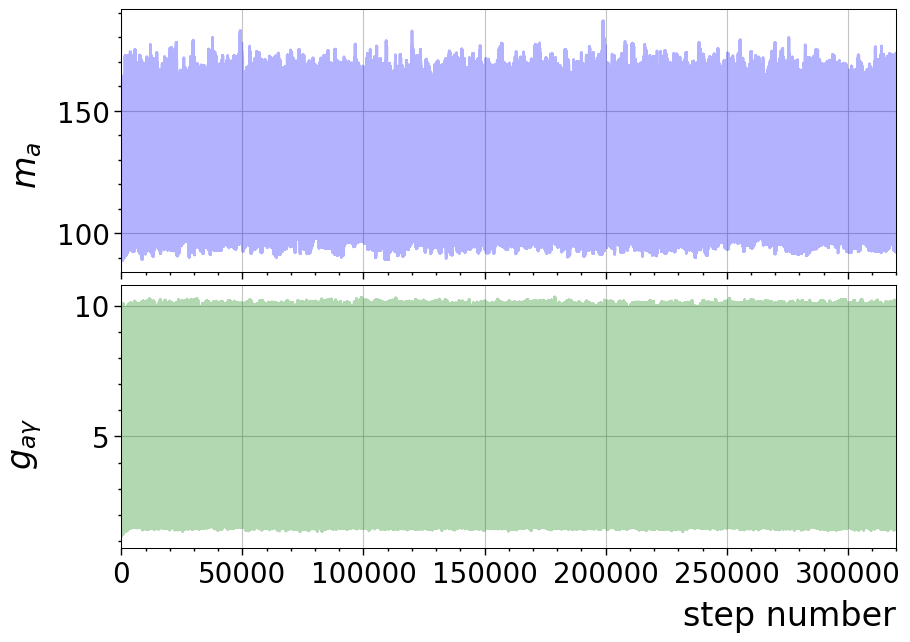

In [7]:
plt.clf
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(flat=True)
labels = [r'$m_a$', r'$g_{a\gamma}$']
ax1 = axes[0]
ax1.plot(samples[:, 0], "b", alpha=0.3)
ax1.set_xlim(0, len(samples))
ax1.set_ylabel(labels[0])
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax2 = axes[1]
ax2.plot(samples[:, 1], "g", alpha=0.3)
ax2.set_xlim(0, len(samples))
ax2.set_ylabel(labels[1])
ax2.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

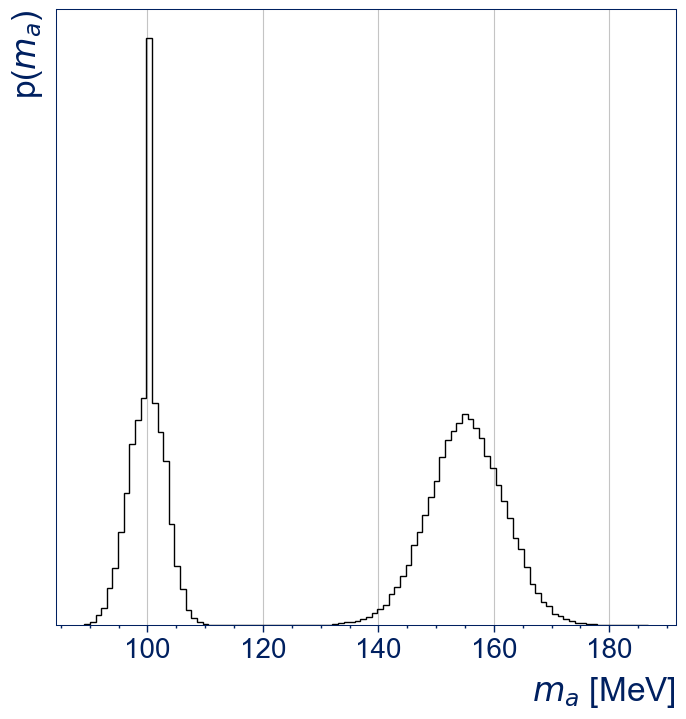

In [13]:
plt.figure(figsize=(8,8))
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r'$m_a$ [MeV]')
plt.ylabel(r"p($m_{a}$)")
plt.gca().set_yticks([])
plt.show()

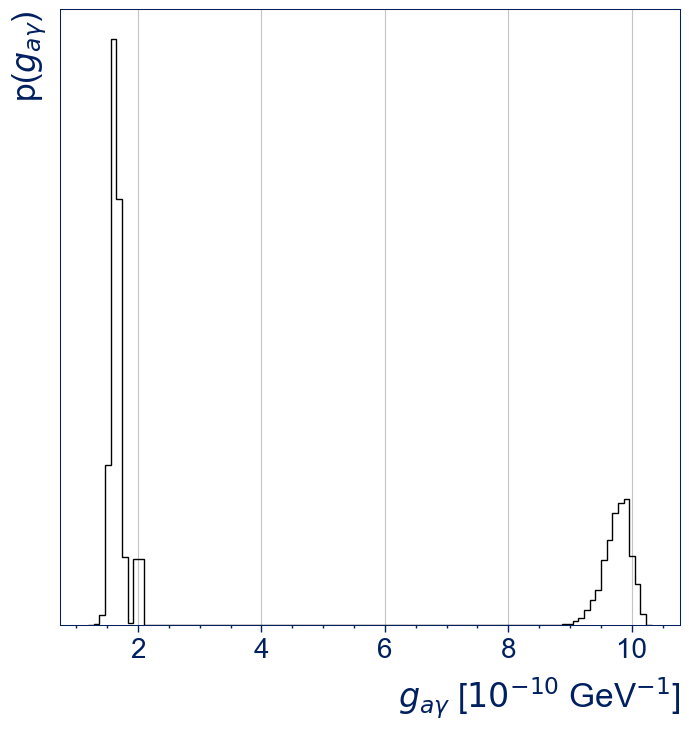

In [14]:
plt.figure(figsize=(8,8))
plt.hist(samples[:, 1], 100, color="k", histtype="step")
plt.xlabel('$g_{a\gamma}$ [$10^{-10}$ GeV$^{-1}$]')
plt.ylabel(r"p($g_{a\gamma}$)")
plt.gca().set_yticks([])
plt.show()

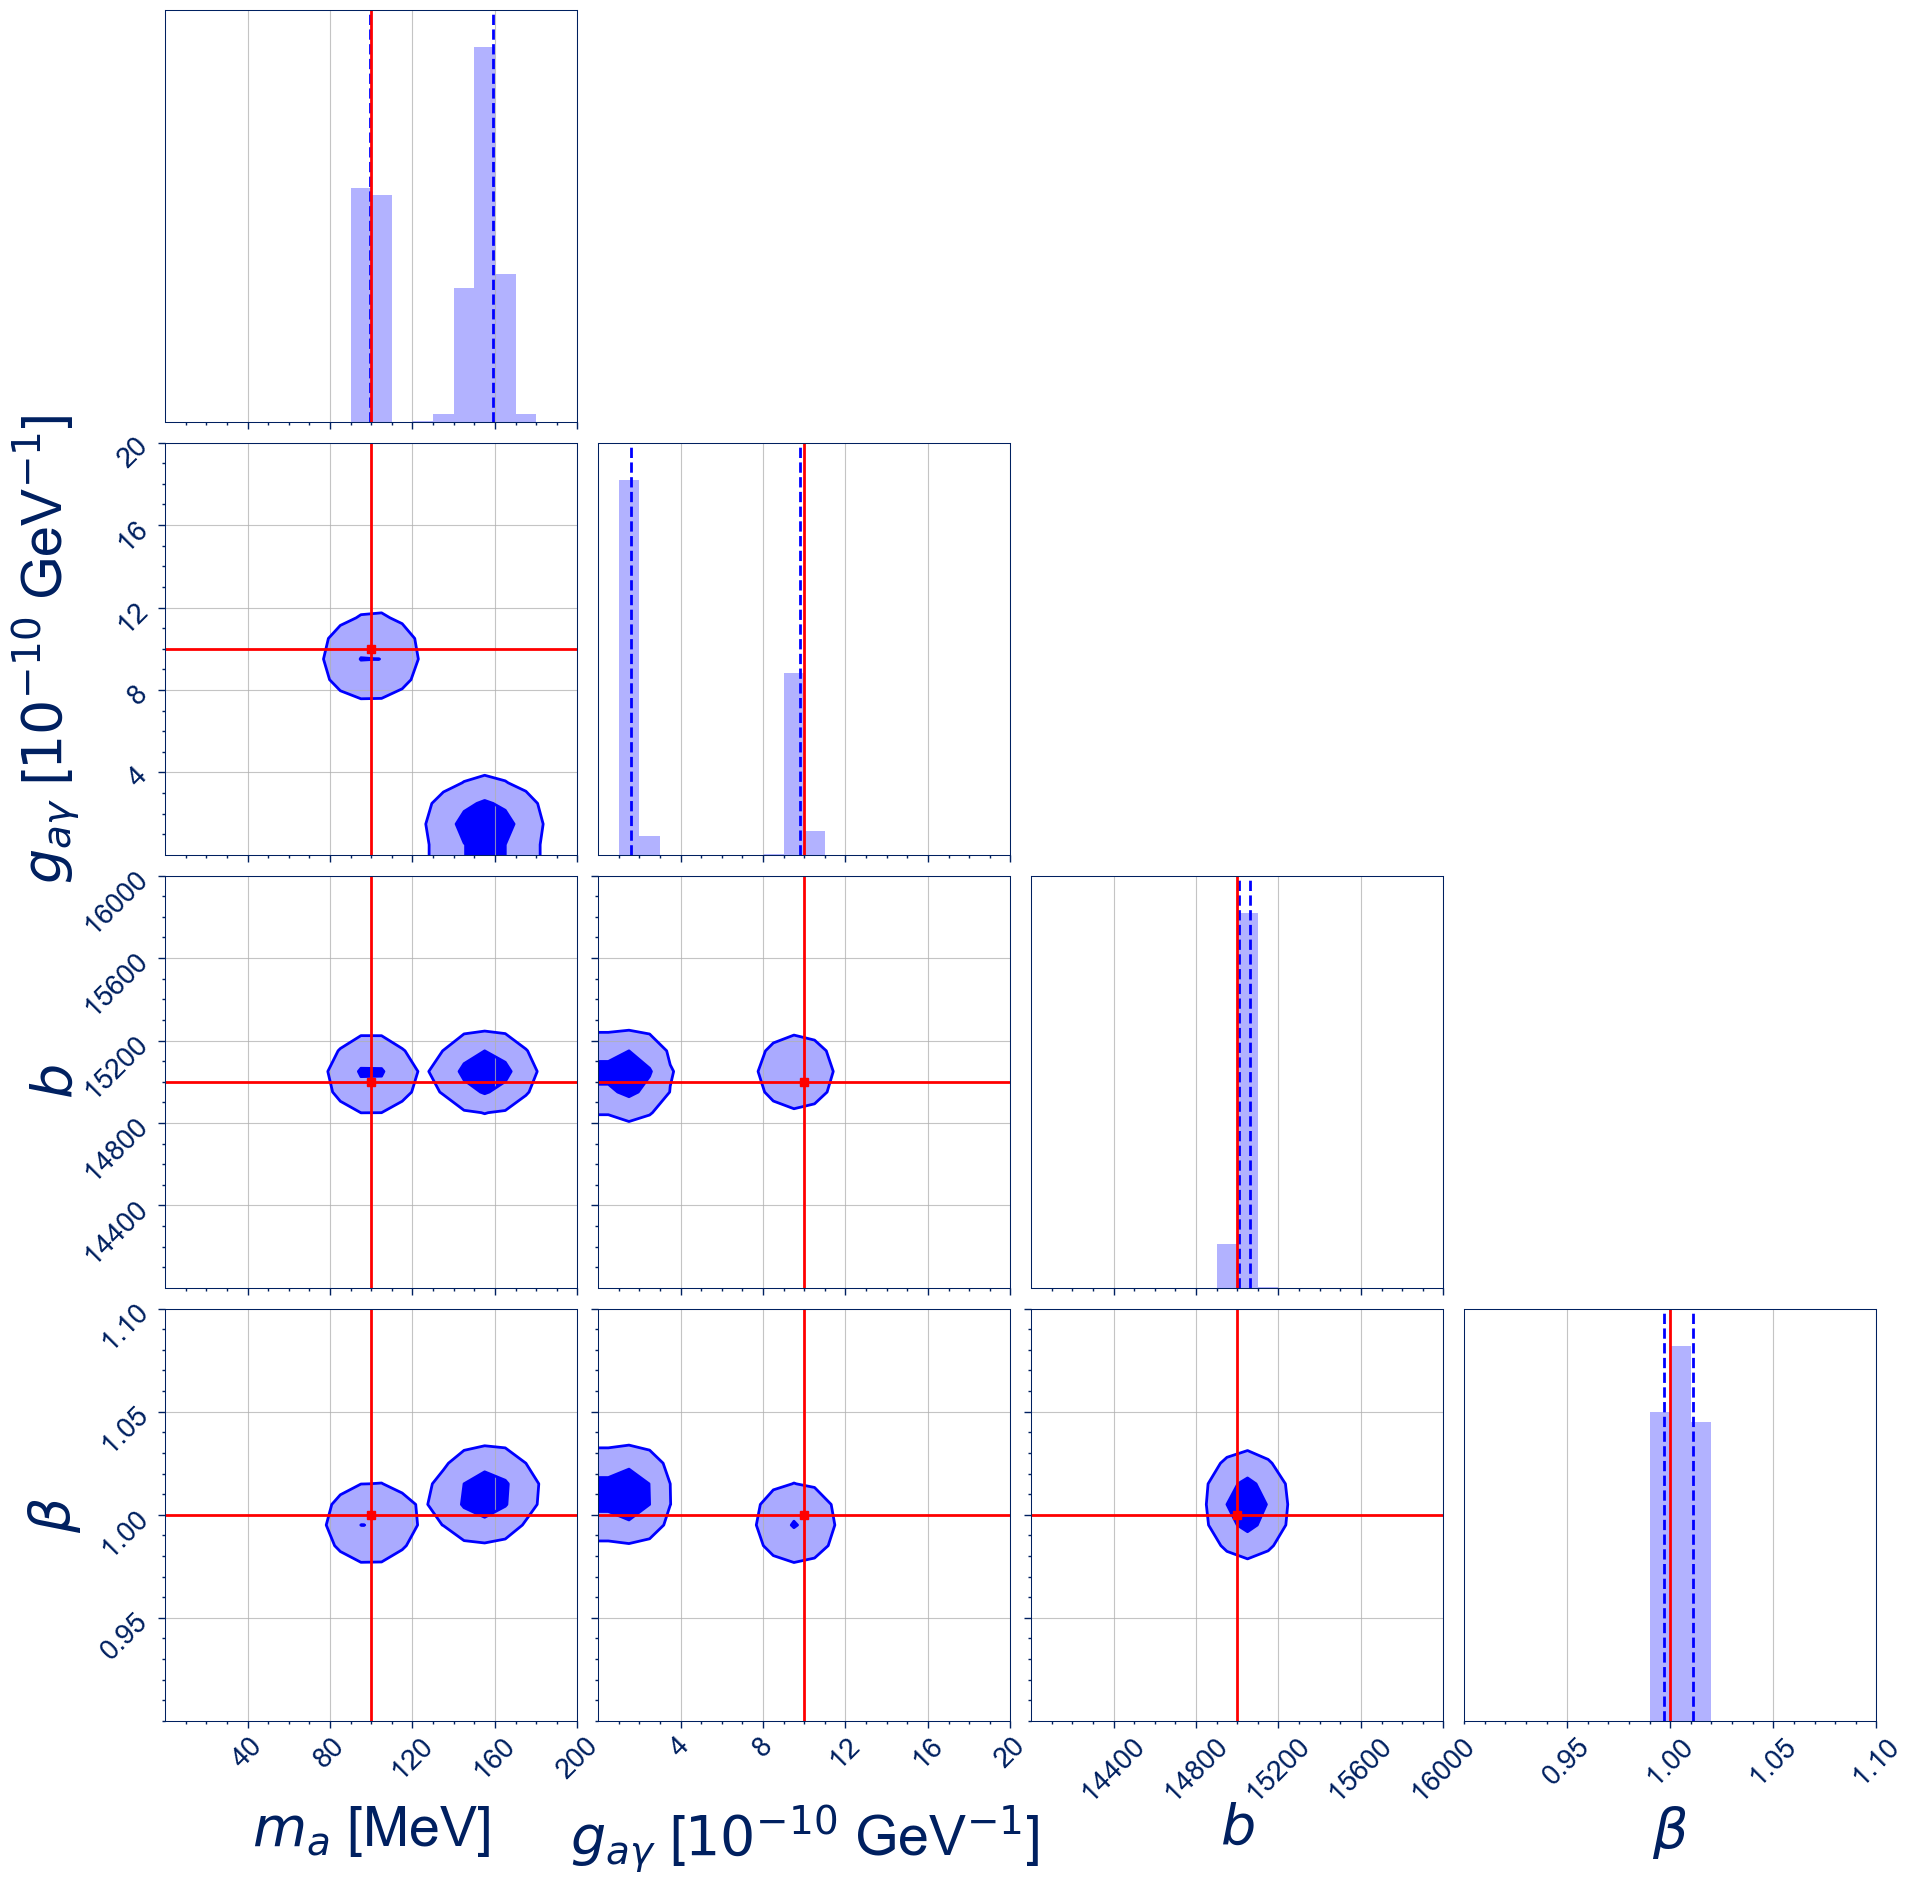

In [11]:
plt.clf
rcParams['figure.facecolor']='none'
rcParams['axes.facecolor']='white'
rcParams['savefig.facecolor']='white'
rcParams['figure.figsize']=(20,20)
rcParams['axes.labelcolor']='002060'
rcParams['axes.edgecolor']='002060'
rcParams['font.sans-serif']='arial'
rcParams['hatch.color']='002060'
rcParams['xtick.color']='002060'
rcParams['ytick.color']='002060'

# figs2 = plt.figure()
# subfig1= figs2.subfigures(ncols=1)
# corner.corner(samples, labels=('$m_a$ [MeV]', '$g_{a\gamma}$ [$10^{-10}$ GeV$^{-1}$]'),label_kwargs={'fontsize': 40,'loc':'center'},smooth=1, labelpad=-0.1, truths=[100,10], levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, color='blue', plot_datapoints=False, fill_contours=True,truth_color='red',range=[(84,112),(8.4,10.8)],fig=subfig1)
# #plt.savefig('./egg7.png',pad_inches=2, bbox_inches='tight')
# plt.show()
# plt.close()

figs2 = plt.figure()
subfig1= figs2.subfigures(ncols=1)
corner.corner(samples,
              labels=('$m_a$ [MeV]', '$g_{a\gamma}$ [$10^{-10}$ GeV$^{-1}$]', '$b$', r'$\beta$'),
              label_kwargs={'fontsize': 40,'loc':'center'},
              smooth=1, 
              labelpad=-0.1, 
              truths=[100,10,15000,1], 
              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
              quantiles=(0.16, 0.84),
              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
              color='blue', 
              plot_datapoints=False,
              fill_contours=True,truth_color='red',
              range=[(0,200), (0,20), (bmin,bmax), (betamin,betamax)],
              fig=subfig1)
#plt.savefig('./egg7.png',pad_inches=2, bbox_inches='tight')
plt.show()
plt.close()